In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, asin, sqrt, pi, atan, atan2, fabs


In [2]:
propiedades = pd.read_csv('properati.csv')
#propiedades = pd.read_csv('/home/agustin/Escritorio/escritorio/fiuba/Organizacion de datos/properati.csv')

/home/mati/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Ya no es necesario 

#Elimino columnas innecesarias
propiedades.drop(['Unnamed: 0'], axis = 1, inplace = True)
propiedades.head(2)


,country_name,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,...,price_aprox_local_currency,price_aprox_usd,price_per_m2,price_usd_per_m2,property_type,rooms,state_name,surface_covered_in_m2,surface_in_m2,surface_total_in_m2
0,NaN,2012-08-08,NaN,850 aprox,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,...,NaN,NaN,NaN,NaN,apartment,3.0,Capital Federal,NaN,102.0,NaN
1,NaN,2012-08-08,NaN,NaN,2013-07-01,11.0,-34.546730,-58.550579,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,...,NaN,NaN,NaN,NaN,apartment,3.0,Bs.As. G.B.A. Zona Norte,NaN,73.0,NaN


In [5]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455309 entries, 0 to 2455308
Data columns (total 21 columns):
country_name                  object
created_on                    object
currency                      object
expenses                      object
fecha_de_publicacion          object
floor                         float64
lat                           float64
lon                           float64
place_name                    object
place_with_parent_names       object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
price_per_m2                  float64
price_usd_per_m2              float64
property_type                 object
rooms                         float64
state_name                    object
surface_covered_in_m2         float64
surface_in_m2                 float64
surface_total_in_m2           float64
dtypes: float64(12), object(9)
memory usage: 393.4+ MB


In [ ]:
#ya no es necesario

#Elimino los registros que no sean de Capital Federal o Gran Buenos Aires
#capital = propiedades ['state_name'] == 'Capital Federal'
#gba = propiedades ['state_name'].str.contains('Bs.As. G.B.A.')
#propiedades = propiedades [capital | gba].reset_index()
#propiedades.drop("index", axis = 1, inplace = True)
#propiedades.info()

# podemos reemplazar es por la siguiente linea creo 
#( no lo hice porque en el repo no esta el csv y no se cual tenias)
# propiedades = propiedades.loc[propiedades.state_name.str.contains('Bs.As. G.B.A.|Capital Federal'),:]

In [7]:
#Compruebo que solo haya capital y gba
propiedades.groupby('state_name').agg(np.size)['floor']

state_name
Bs.As. G.B.A. Zona Norte    820412.0
Bs.As. G.B.A. Zona Oeste    466592.0
Bs.As. G.B.A. Zona Sur      238355.0
Capital Federal             929950.0
Name: floor, dtype: float64

In [8]:
#Reemplazo todos los tipos de Palermo por uno unico
propiedades.loc[propiedades.place_name.str.contains("Palermo", na = False),'place_name'] = 'Palermo'
propiedades.loc[propiedades.place_name.str.contains("Palermo", na = False),'place_name'].value_counts()

Palermo    101725
Name: place_name, dtype: int64

In [10]:
def unificar_superficie(fila):
    s3,s2,s1 = fila
    if (s3 and not np.isnan(s3)):
        return s3
    if (s2 and not np.isnan(s2)):
        return s2
    if (s1 and not np.isnan(s1)):
        return s1
    return np.nan

In [11]:
#Unifico las superficies
propiedades.loc[:,'superficie'] = propiedades.loc[:,['surface_covered_in_m2','surface_in_m2','surface_total_in_m2']].apply(unificar_superficie, axis = 1)
propiedades.drop(['surface_covered_in_m2','surface_in_m2','surface_total_in_m2'], axis = 1, inplace = True)
propiedades.head(2)

,country_name,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,price_usd_per_m2,property_type,rooms,state_name,superficie
0,NaN,2012-08-08,NaN,850 aprox,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,NaN,NaN,NaN,NaN,NaN,apartment,3.0,Capital Federal,102.0
1,NaN,2012-08-08,NaN,NaN,2013-07-01,11.0,-34.546730,-58.550579,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,NaN,NaN,NaN,NaN,NaN,apartment,3.0,Bs.As. G.B.A. Zona Norte,73.0


In [12]:
def calcularPrecioM2(fila):
    """Recibe una lista con precio total, superficie total, superficie cubierta y precio por metro cuadrado,
    y calcula este ultimo a partir de los anteriores, cuando es posible"""
    precio_total,precio_m2, superficie = fila
    if (np.isnan(precio_m2)):
        if (not np.isnan(superficie)):
            return precio_total/superficie
    return precio_m2

In [13]:
#Calculo el precio por metro cuadrado a partir del precio total y la superficie
propiedades.loc[:,'price_usd_per_m2'] = propiedades.loc[:,['price_aprox_usd','price_usd_per_m2', 'superficie']].apply(calcularPrecioM2,axis = 1)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455309 entries, 0 to 2455308
Data columns (total 19 columns):
country_name                  object
created_on                    object
currency                      object
expenses                      object
fecha_de_publicacion          object
floor                         float64
lat                           float64
lon                           float64
place_name                    object
place_with_parent_names       object
price                         float64
price_aprox_local_currency    float64
price_aprox_usd               float64
price_per_m2                  float64
price_usd_per_m2              float64
property_type                 object
rooms                         float64
state_name                    object
superficie                    float64
dtypes: float64(10), object(9)
memory usage: 355.9+ MB


### Como es el precio por metro cuadrado en cada zona? Cuales son los barrios con mayor promedio?

In [14]:
tiene_precio = propiedades['price_usd_per_m2'].notnull()

In [15]:
precio_por_zona = propiedades[tiene_precio].loc[:,['state_name','price_usd_per_m2']].groupby('state_name').agg([np.size,np.mean])
precio_por_zona

price_usd_per_m2             
                                     size         mean
state_name                                            
Bs.As. G.B.A. Zona Norte         610208.0  1817.803098
Bs.As. G.B.A. Zona Oeste         267045.0  1643.227348
Bs.As. G.B.A. Zona Sur           130474.0  1869.231481
Capital Federal                  680996.0  2673.721446

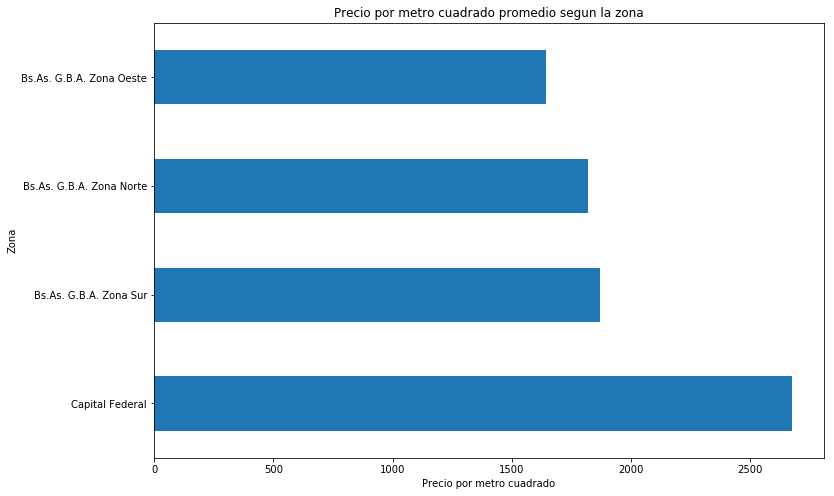

In [16]:
plot = precio_por_zona[('price_usd_per_m2','mean')].sort_values(ascending = False).plot(kind='barh', title = "Precio por metro cuadrado promedio segun la zona", figsize=(12,8));
plot.set_ylabel("Zona")
plot.set_xlabel("Precio por metro cuadrado")

### Para capital federal

In [17]:
precios_capital = propiedades[tiene_precio].loc[propiedades.state_name == 'Capital Federal',['place_name','price_usd_per_m2']]
precios_capital = precios_capital.groupby('place_name').agg([np.size,np.mean])
precios_capital.describe()

price_usd_per_m2             
                  size         mean
count        63.000000    63.000000
mean      10809.460317  2370.013342
std       15125.940064   843.571215
min           1.000000   946.108213
25%        1640.500000  1914.892928
50%        6073.000000  2217.494399
75%       12592.000000  2535.846514
max       73901.000000  6392.615387

In [18]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_capital = precios_capital[precios_capital[('price_usd_per_m2','size')] > 800]

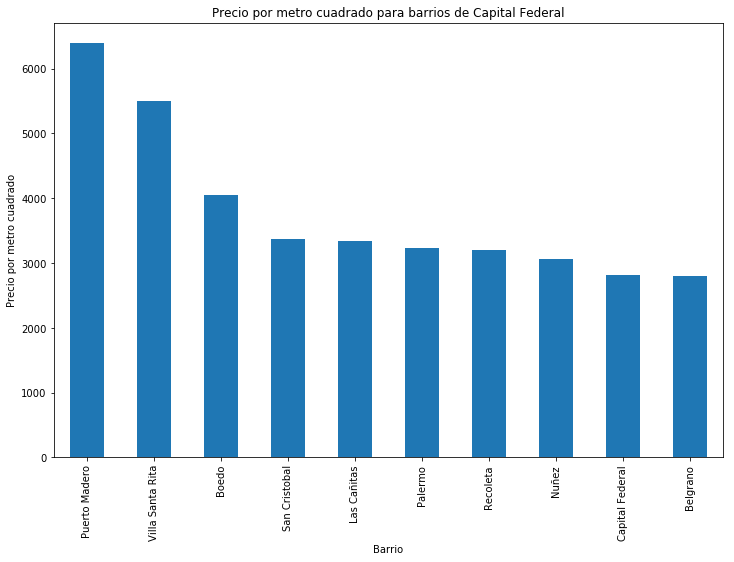

In [19]:
plot = precios_capital[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar', figsize=(12,8));
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de Capital Federal")

### Para gba zona norte

In [20]:
precios_zona_norte = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Norte'),['place_name','price_usd_per_m2']]
precios_zona_norte = precios_zona_norte.groupby('place_name').agg([np.size,np.mean])
precios_zona_norte.describe()

price_usd_per_m2              
                  size          mean
count       340.000000    340.000000
mean       1794.217647   1684.577780
std        7414.215056   1945.461670
min           1.000000     86.700571
25%          17.000000   1007.050859
50%          69.000000   1290.205656
75%         260.250000   1857.814938
max       68810.000000  28194.815849

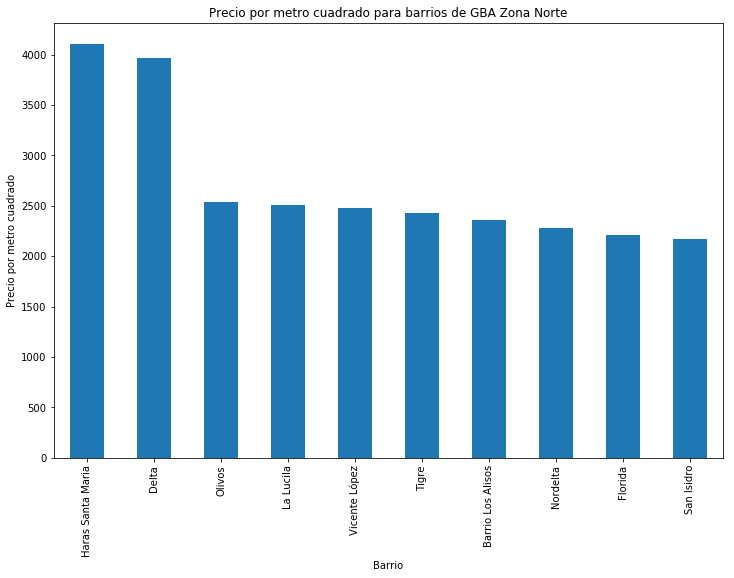

In [21]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_norte = precios_zona_norte[precios_zona_norte[('price_usd_per_m2','size')] > 800]
plot = precios_zona_norte[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar', figsize=(12,8));
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Norte")

### Para gba zona oeste

In [22]:
precios_zona_oeste = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Oeste'),['place_name','price_usd_per_m2']]
precios_zona_oeste = precios_zona_oeste.groupby('place_name').agg([np.size,np.mean])
precios_zona_oeste.describe()

price_usd_per_m2              
                  size          mean
count        88.000000     88.000000
mean       3034.602273   1402.926238
std        7045.519291   1558.779652
min           1.000000     40.870430
25%          66.750000    770.781965
50%         346.000000   1055.920853
75%        2194.750000   1539.934805
max       48490.000000  11598.750000

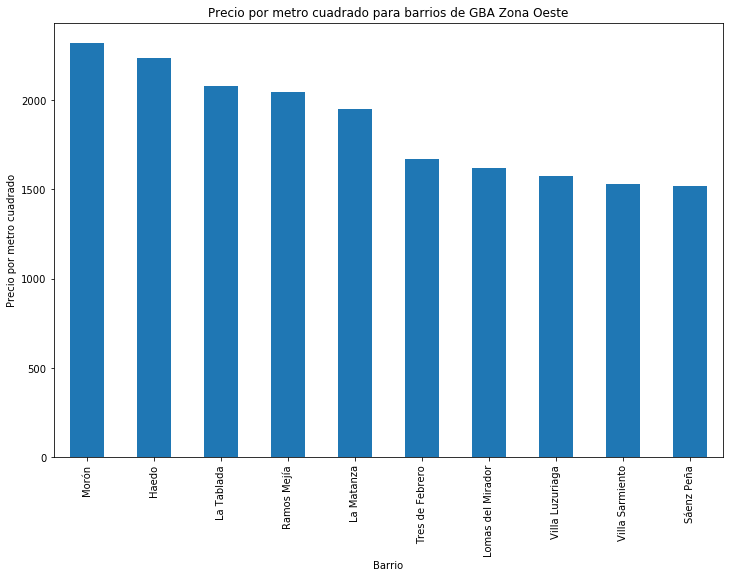

In [23]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_oeste = precios_zona_oeste[precios_zona_oeste[('price_usd_per_m2','size')] > 800]
plot = precios_zona_oeste[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar', figsize=(12,8));
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Oeste")

### Para gba zona sur

In [24]:
precios_zona_sur = propiedades[tiene_precio].loc[propiedades.state_name.str.contains('Zona Sur'),['place_name','price_usd_per_m2']]
precios_zona_sur = precios_zona_sur.groupby('place_name').agg([np.size,np.mean])
precios_zona_sur.describe()

price_usd_per_m2               
                  size           mean
count       146.000000     146.000000
mean        893.657534    2346.721021
std        2470.142513    9129.671926
min           1.000000       0.000000
25%          25.000000     646.549596
50%          76.500000    1096.637587
75%         466.250000    1598.536435
max       22160.000000  102857.142857

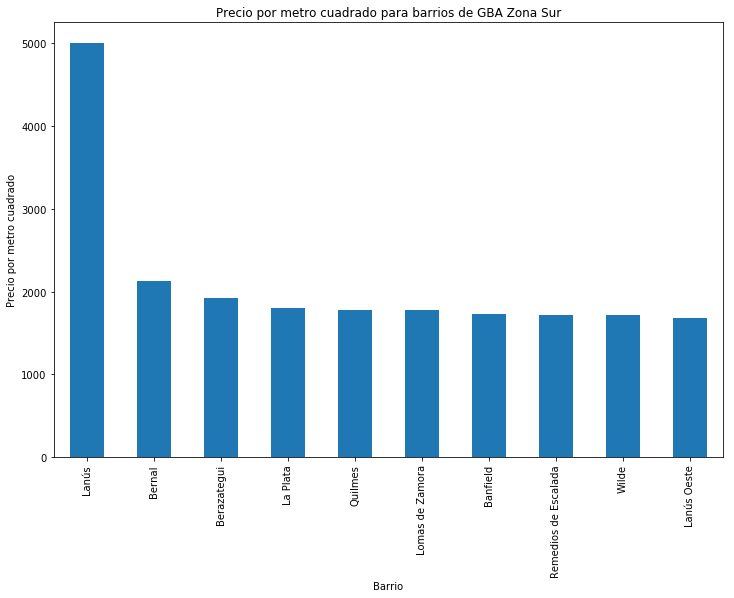

In [25]:
#Tomamos solo aquellos barrios que tengan mas de 800 publicaciones
precios_zona_sur = precios_zona_sur[precios_zona_sur[('price_usd_per_m2','size')] > 800]
plot = precios_zona_sur[('price_usd_per_m2','mean')].sort_values(ascending = False).head(10).plot(kind='bar', figsize=(12,8));
plot.set_xlabel("Barrio")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Precio por metro cuadrado para barrios de GBA Zona Sur")

### Como evoluciono el precio por metro cuadrado al pasar los anios?

In [26]:
def obtener_anio(fecha):
    return fecha.split('-')[0]


In [27]:
def obtener_mes(fecha):
    return fecha.split('-')[1]

In [28]:
propiedades.loc[:,'Year'] = propiedades.loc[:,'fecha_de_publicacion'].apply(obtener_anio)
propiedades.loc[:,'Month'] = propiedades.loc[:,'fecha_de_publicacion'].apply(obtener_mes)
propiedades.tail(3)

,country_name,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,...,price_aprox_local_currency,price_aprox_usd,price_per_m2,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month
2455306,Argentina,2017-07-03,USD,NaN,2017-06-03,NaN,-34.637550,-58.457527,Flores,|Argentina|Capital Federal|Flores|,...,1961396.0,118000.0,2565.217391,2226.415094,apartment,1.0,Capital Federal,46.0,2017,06
2455307,Argentina,2017-07-03,USD,NaN,2017-06-03,NaN,-34.617721,-58.383034,Monserrat,|Argentina|Capital Federal|Monserrat|,...,1346382.0,81000.0,2531.250000,2189.189189,apartment,1.0,Capital Federal,32.0,2017,06
2455308,Argentina,2017-07-03,USD,1500,2017-06-03,NaN,-34.628002,-58.433828,Caballito,|Argentina|Capital Federal|Caballito|,...,1446114.0,87000.0,NaN,2289.473684,apartment,1.0,Capital Federal,38.0,2017,06


In [29]:
precio_por_anio = propiedades[tiene_precio].loc[:,['Year','price_usd_per_m2']].groupby('Year').agg([np.size,np.mean])
precio_por_anio = precio_por_anio.loc[precio_por_anio[('price_usd_per_m2','size')] > 100,:]
precio_por_anio

price_usd_per_m2             
                 size         mean
Year                              
2013         199349.0  2369.190254
2014         345284.0  1890.479226
2015         450676.0  1714.803593
2016         311484.0  2151.086818
2017         381930.0  2735.672688

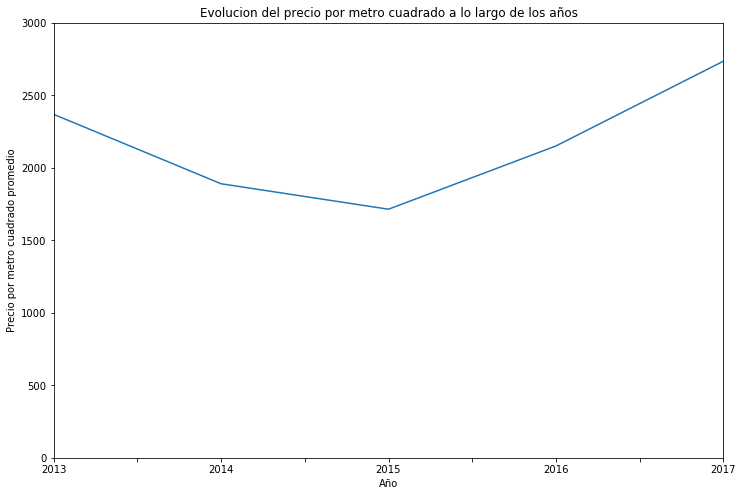

In [30]:
plot = precio_por_anio[('price_usd_per_m2','mean')].plot(figsize=(12,8));
plot.set_xlabel("Año")
plot.set_ylabel("Precio por metro cuadrado promedio")
plot.set_ylim([0,3000])
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los años")

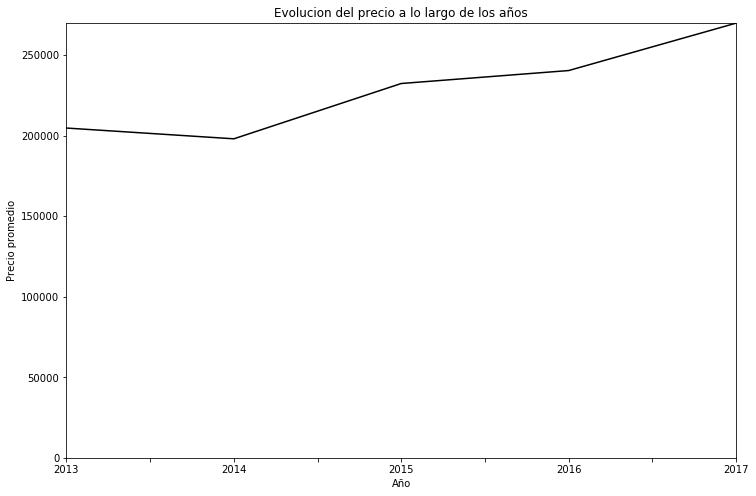

In [31]:
precio_por_anio2 = propiedades.loc[propiedades.price_aprox_usd.notnull(),['Year','price_aprox_usd']].groupby('Year').agg([np.size,np.mean])
precio_por_anio2 = precio_por_anio2.loc[precio_por_anio2[('price_aprox_usd','size')] > 100,:]
plot = precio_por_anio2[('price_aprox_usd','mean')].plot(figsize=(12,8), color='black');
plot.set_xlabel("Año")
plot.set_ylabel("Precio promedio")
plot.set_ylim([0,270000])
plot.set_title("Evolucion del precio a lo largo de los años")

### Como evoluciono el precio por metro cuadrado en en cada anio?

In [32]:
precios_2016 = propiedades[tiene_precio].loc[propiedades.Year == '2016',['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)
precios_2015 = propiedades[tiene_precio].loc[propiedades.Year == '2015',['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)
precios_2014 = propiedades[tiene_precio].loc[propiedades.Year == '2014',['Month','price_usd_per_m2']].groupby('Month').agg(np.mean)


In [33]:
precios_2016 = precios_2016.rename(columns={'price_usd_per_m2': '2016'}).reset_index()
precios_2015 = precios_2015.rename(columns={'price_usd_per_m2': '2015'}).reset_index()
precios_2014 = precios_2014.rename(columns={'price_usd_per_m2': '2014'}).reset_index()
precios = pd.merge(precios_2016,precios_2015,on='Month',how='outer')
precios = pd.merge(precios,precios_2014,on='Month',how='outer')
precios.set_index('Month', inplace = True)
precios

,2016,2015,2014
Month,,,
01,1831.190767,1677.568481,2102.573404
02,1849.816972,1723.479619,2079.900913
03,1966.921313,1565.270512,1912.878483
04,2059.532984,1583.533208,1928.181890
05,2078.260781,1607.606635,1911.892901
06,2095.725003,1629.178322,1928.651897
07,2160.555576,1618.955606,1938.728071
08,2208.922107,1712.221020,1697.860709
09,2231.013673,1657.230560,1657.700065


(0, 3000)

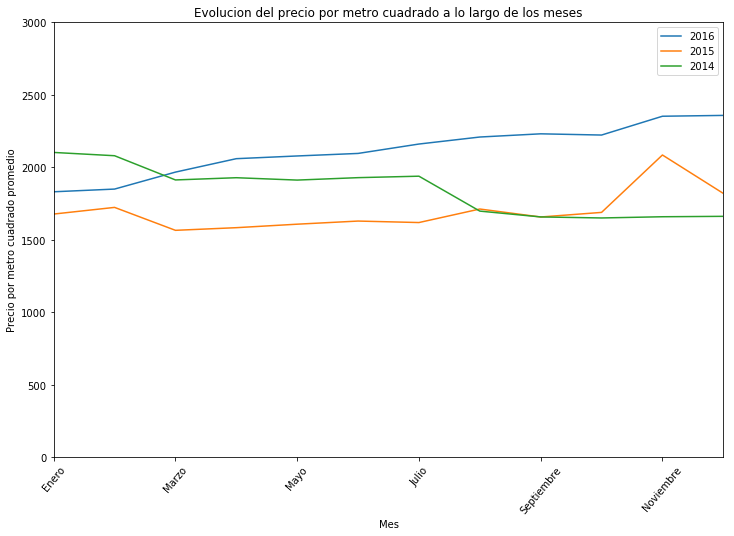

In [34]:
precios.index = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto',\
                 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plot = precios.plot(figsize=(12,8),rot = 50);
plot.set_xlabel("Mes")
plot.set_ylabel("Precio por metro cuadrado promedio")
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los meses")
plot.set_ylim([0,3000])


### Que tipo de propiedad se vende mas?

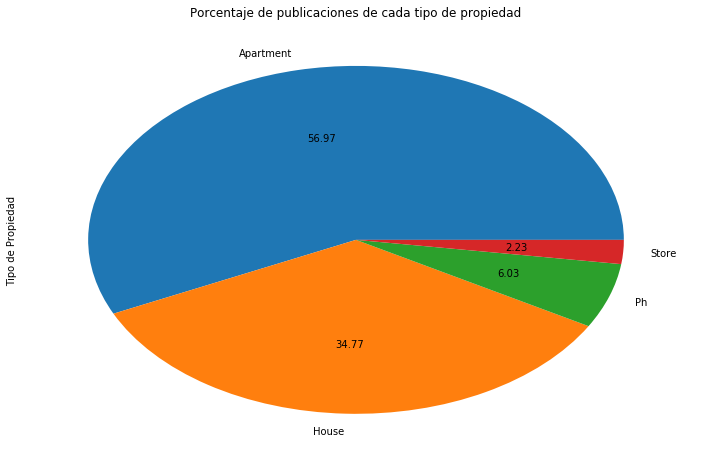

In [35]:
tipos_propiedades = propiedades.loc[:,'property_type'].str.capitalize().value_counts()
plot = tipos_propiedades.plot(kind='pie', figsize=(12,8), autopct='%.2f', label = 'Tipo de Propiedad');
plot.set_title("Porcentaje de publicaciones de cada tipo de propiedad")

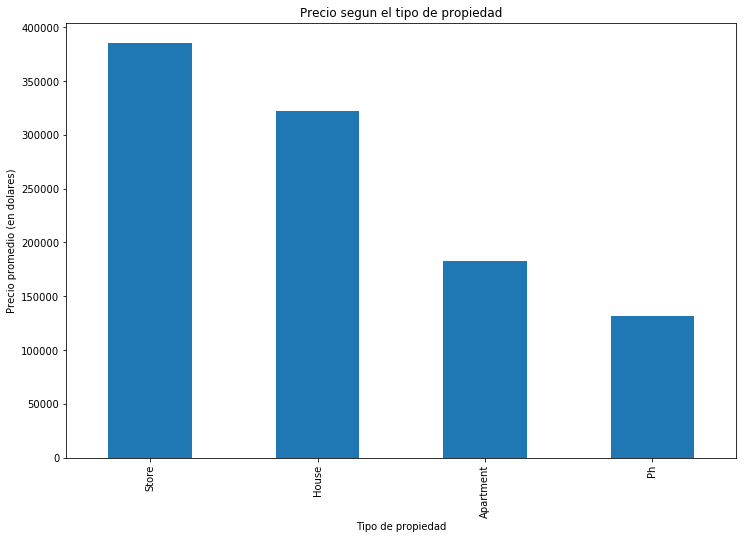

In [37]:
precio_tipos_propiedades = propiedades.loc[:,['property_type','price_aprox_usd']]
precio_tipos_propiedades.loc[:,'property_type'] = precio_tipos_propiedades.loc[:,'property_type'].str.capitalize()
precio_tipos_propiedades = precio_tipos_propiedades.groupby('property_type').agg([np.size,np.mean])
plot = precio_tipos_propiedades.loc[:,('price_aprox_usd','mean')].sort_values(ascending=False).plot(kind = 'bar', figsize=(12,8));

plot.set_xlabel("Tipo de propiedad")
plot.set_ylabel("Precio promedio (en dolares)")
plot.set_title("Precio segun el tipo de propiedad")

### Cual es la relacion entre la superficie cubierta y la cantidad de habitaciones?

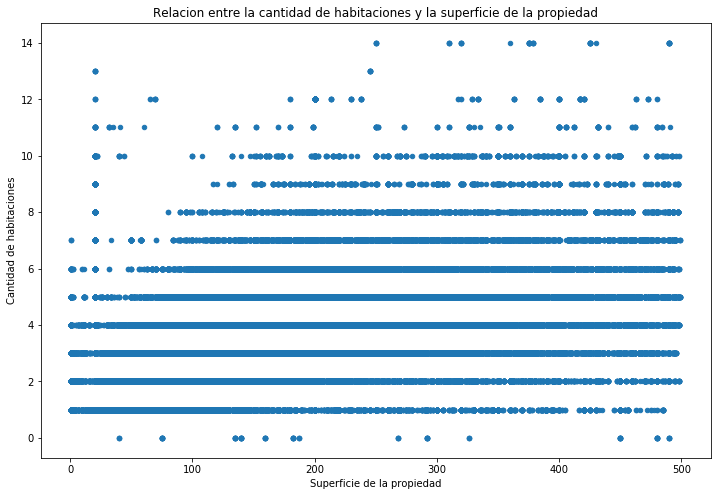

In [40]:
tiene_superficie = propiedades['superficie'].notnull()
tiene_habitaciones = propiedades['rooms'].notnull()
habitaciones = propiedades.loc[tiene_superficie & tiene_habitaciones,:]
habitaciones = habitaciones.loc[(habitaciones['superficie'] < 500) & (habitaciones['rooms'] < 15 ),:]
plot = habitaciones.plot.scatter(x = 'superficie', y = 'rooms', figsize=(12,8));
plot.set_xlabel("Superficie de la propiedad")
plot.set_ylabel("Cantidad de habitaciones")
plot.set_title("Relacion entre la cantidad de habitaciones y la superficie de la propiedad")

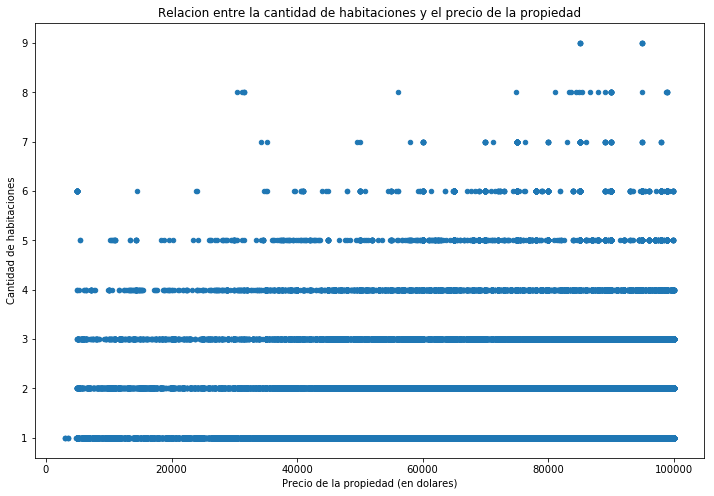

In [41]:
tiene_precio_usd = propiedades['price_aprox_usd'].notnull()
tiene_habitaciones = propiedades['rooms'].notnull() & propiedades['rooms'] > 0
hab = propiedades.loc[tiene_precio_usd & tiene_habitaciones,:]
hab = hab.loc[(hab['price_aprox_usd'] > 1000) & (hab['price_aprox_usd'] < 100000) & (hab['rooms'] < 10),:]
plot = hab.plot.scatter(x = 'price_aprox_usd', y = 'rooms', figsize=(12,8));
plot.set_xlabel("Precio de la propiedad (en dolares)")
plot.set_ylabel("Cantidad de habitaciones")
plot.set_title("Relacion entre la cantidad de habitaciones y el precio de la propiedad")

##### se ve que las propiedades mas baratas no tiene mas de 4-5 habitaciones y que solo las mas caras tiene mas de 6

### Relacion entre los distintos valores de dolar (Creo que no sirve para comparar)

In [46]:
valor_dolar = propiedades.loc[(propiedades['price_aprox_local_currency'].notnull()) & (propiedades['price_aprox_usd'].notnull()),['price_aprox_local_currency','price_aprox_usd','Year']]
valor_dolar ['dolar'] = valor_dolar['price_aprox_local_currency'] / valor_dolar['price_aprox_usd']
#valor_dolar = valor_dolar[valor_dolar ['dolar'] > 10]
valor_dolar.describe()

,price_aprox_local_currency,price_aprox_usd,dolar
count,2.143095e+06,2.143095e+06,2.123129e+06
mean,2.624328e+06,2.301209e+05,1.101820e+01
std,4.536521e+06,3.535100e+05,3.883765e+00
min,0.000000e+00,0.000000e+00,5.347992e+00
25%,8.632503e+05,9.000000e+04,8.386000e+00
50%,1.503608e+06,1.430000e+05,9.198400e+00
75%,2.874330e+06,2.550000e+05,1.596850e+01
max,8.014550e+08,5.000000e+07,1.662200e+01


In [47]:
valor_dolar = valor_dolar.loc[:,['Year', 'dolar']].groupby('Year').agg(np.mean)
valor_dolar

,dolar
Year,
2013,5.808153
2014,8.081192
2015,9.401477
2016,15.968500
2017,16.128413


## Tomamos algunos barrios importantes y hacemos comparaciones

In [48]:
barrios = ['Palermo', 'Olivos', 'Lomas de Zamora', 'La Matanza']
df = []
for barrio in barrios:
    a = propiedades[tiene_precio].loc[propiedades.place_name == barrio,['Year','price_usd_per_m2']]\
    .groupby('Year').agg(np.mean).reset_index().rename(columns={'price_usd_per_m2' : barrio})
    df.append(a)

In [49]:
precios_barrios = df[0]
for x in range (1,len(barrios)):
    precios_barrios = pd.merge(precios_barrios,df[x],how='outer')
precios_barrios.set_index("Year",inplace = True)
precios_barrios

,Palermo,Olivos,Lomas de Zamora,La Matanza
Year,,,,
2013,3045.593394,2703.427414,2468.826751,2821.583231
2014,2965.790436,2389.174630,1587.086071,1867.924150
2015,3139.452200,2113.209897,1592.004317,1625.846192
2016,3318.524747,2880.010174,1612.371211,1930.060818
2017,3601.772003,2831.845297,1997.987134,1888.998619


(0, 3600)

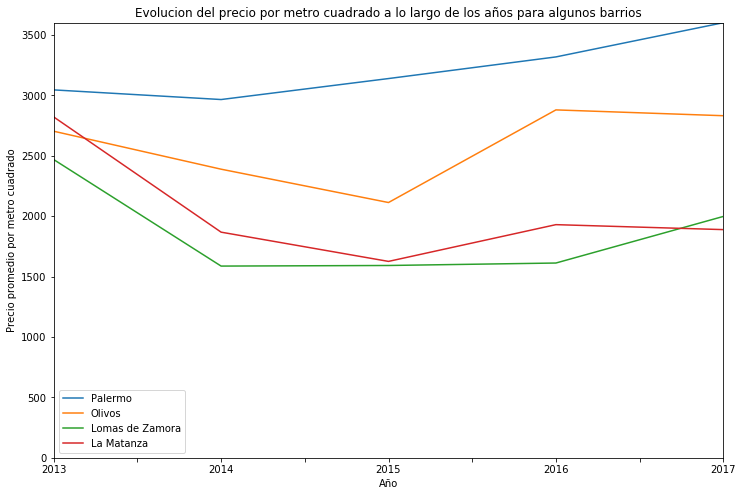

In [50]:
plot = precios_barrios.plot(figsize=(12,8));
plot.set_xlabel("Año")
plot.set_ylabel("Precio promedio por metro cuadrado")
plot.set_title("Evolucion del precio por metro cuadrado a lo largo de los años para algunos barrios")
plot.set_ylim([0,3600])

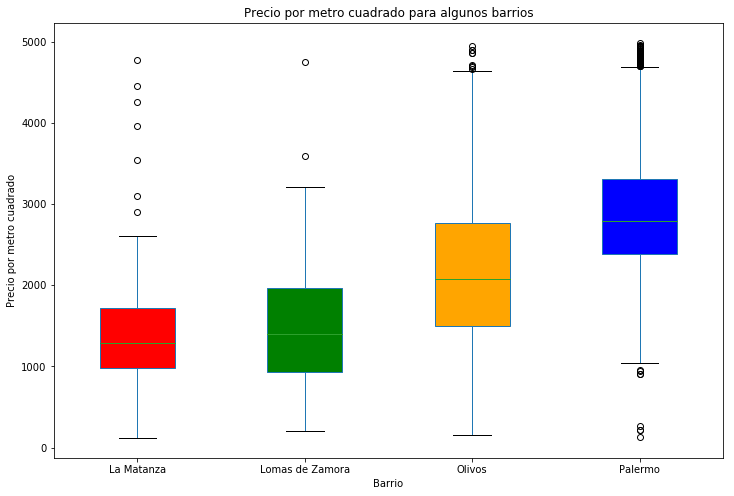

In [51]:
precios_barrios2 = propiedades.loc[(propiedades.Year == '2016') & (propiedades.price_usd_per_m2 < 5000) &\
                        (propiedades.price_usd_per_m2 > 100)&((propiedades.place_name == barrios[0]) | \
                          (propiedades.place_name == barrios[1]) | (propiedades.place_name == barrios[2])\
                        | (propiedades.place_name == barrios[3])),\
        ['lon','place_name','price_usd_per_m2']].pivot_table(index='lon',columns='place_name')
precios_barrios2.columns = precios_barrios2.columns.droplevel()
boxplot = precios_barrios2.plot.box(figsize=(12,8),patch_artist=True,return_type='dict', title="Precio por metro cuadrado para algunos barrios");
ax=plt.gca()
ax.set_ylabel('Precio por metro cuadrado')
ax.set_xlabel('Barrio')


colors = ['red' , 'green', 'orange', 'blue'] #Mismos colores del grafico de lineas de arriba
    
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)


## Relacion entre precios y distancia a lugares importantes

In [76]:
solo_capital = pd.read_csv('solo_capital.csv')

#Lo exporte a csv porque tardaba mucho los calculos de distancia

/home/mati/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
def calcular_distancia(lat1,long1,lat2,long2):
    lon1, lat1 = (radians(coord) for coord in (long1,lat1))
    lon2, lat2 = (radians(coord) for coord in (long2,lat2))
    dlat = (lat2 - lat1)
    dlon = (lon2 - lon1)
    a = (
        sin(dlat * 0.5)**2 +
        cos(lat1) * cos(lat2) * sin(dlon * 0.5)**2
    )
    
    radioTierra = 6371008.8
    return 2 * radioTierra * asin(sqrt(a)) / 1000

#https://gist.github.com/habibutsu/8bbcc202a915e965c6a6d4f561d0e482

In [78]:
def calcular_distancia_minima(fila, distancia_minima):

    lugares = ['Obelisco','Cabildo','Planetario','Jardin Botanico','Abasto','Museo del arte']
    latitudes = [-34.603075,-38.4833,-34.569722,-34.582639,-34.603611,-34.57722222]
    longitudes = [-58.381653,-61.9,-58.411667,-58.417361,-58.410833,-58.40336111]
    lat1,long1 = fila
    distancias = []
    
    for i in range(len(lugares)):
        distancia = calcular_distancia(lat1,long1,latitudes[i],longitudes[i])
        distancias.append(distancia)
        if (distancia <= distancia_minima):
            return distancia
    
    return min(distancias)

In [79]:
#solo_capital = propiedades.loc[(propiedades.state_name == 'Capital Federal') & (propiedades.lat.notnull()) & (propiedades.lon.notnull()),:]
#solo_capital = solo_capital.loc[((solo_capital.lat <= -32) & (solo_capital.lat >= -36)),:]
#solo_capital = solo_capital.loc[((solo_capital.lon <= -56) & (solo_capital.lon >= -63)),:]
#solo_capital.loc[:,'distancia_monumentos'] = solo_capital.loc[:,['lat','lon']].apply(lambda x: calcular_distancia_minima(x,0.5), axis = 1)
solo_capital.head(2)

,country_name,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,...,price_per_m2,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month,distancia_subtes,distancia_monumentos
0,NaN,2012-08-08,NaN,850 aprox,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,...,NaN,NaN,apartment,3.0,Capital Federal,102.0,2013,7,0.649099,4.930767
1,NaN,2012-08-08,USD,NaN,2013-07-01,10.0,-34.597915,-58.417149,Palermo,|Argentina|Capital Federal|Palermo|,...,NaN,2716.40625,apartment,1.0,Capital Federal,32.0,2013,7,0.680153,0.857521


In [75]:
#solo_capital.to_csv('solo_capital.csv', index = False)

#para exportar a csv

In [80]:
solo_capital['distancia_monumentos'].describe()

count    854797.000000
mean          4.366964
std           6.579666
min           0.023206
25%           1.469629
50%           3.046057
75%           5.600211
max         450.296945
Name: distancia_monumentos, dtype: float64

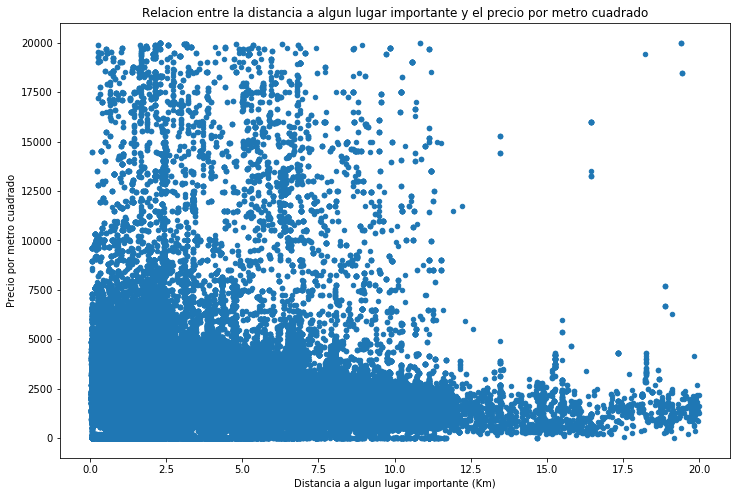

In [81]:
dist = solo_capital.loc[(solo_capital.price_usd_per_m2.notnull()) & (solo_capital.price_usd_per_m2 < 20000) & (solo_capital.distancia_monumentos < 20),:]
plot = dist.plot.scatter(x = 'distancia_monumentos', y = 'price_usd_per_m2', figsize=(12,8));
plot.set_xlabel("Distancia a algun lugar importante (Km)")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Relacion entre la distancia a algun lugar importante y el precio por metro cuadrado")

## Relacion entre el precio y cercania a los subtes

In [82]:
# Datos obtenidos en https://data.buenosaires.gob.ar/
subtes = pd.read_csv('estaciones-de-subte.csv', sep = ",")
subtes.tail()

,X,Y,ID,ESTACION,LINEA
81,-58.469640,-34.630707,83.0,SAN PEDRITO,A
82,-58.463541,-34.629087,82.0,SAN JOSE DE FLORES,A
83,-58.403721,-34.598455,84.0,CORDOBA,H
84,-58.397216,-34.587462,85.0,LAS HERAS,H
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H


In [68]:
subtes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
X           86 non-null float64
Y           86 non-null float64
ID          86 non-null float64
ESTACION    86 non-null object
LINEA       86 non-null object
dtypes: float64(3), object(2)
memory usage: 3.4+ KB


In [69]:
def distancia_subtes(fila, d_max):
    lat, lon = fila
    distancias = []
    for i in range (len(subtes)):
        d = calcular_distancia(lat,lon,subtes.Y[i], subtes.X[i])
        if d <= d_max:
            return d
        distancias.append(d)
    return min(distancias)

In [83]:
#Tardo media hora   lo exporte a csv


#solo_capital.loc[:,'distancia_subtes'] = solo_capital.loc[:,['lat','lon']].apply(lambda x: distancia_subtes(x,0.5), axis = 1)
solo_capital.head(2)

,country_name,created_on,currency,expenses,fecha_de_publicacion,floor,lat,lon,place_name,place_with_parent_names,...,price_per_m2,price_usd_per_m2,property_type,rooms,state_name,superficie,Year,Month,distancia_subtes,distancia_monumentos
0,NaN,2012-08-08,NaN,850 aprox,2013-07-01,10.0,-34.561208,-58.464514,Belgrano,|Argentina|Capital Federal|Belgrano|,...,NaN,NaN,apartment,3.0,Capital Federal,102.0,2013,7,0.649099,4.930767
1,NaN,2012-08-08,USD,NaN,2013-07-01,10.0,-34.597915,-58.417149,Palermo,|Argentina|Capital Federal|Palermo|,...,NaN,2716.40625,apartment,1.0,Capital Federal,32.0,2013,7,0.680153,0.857521


In [84]:
solo_capital['distancia_subtes'].describe()
#cercanos_subte['distancia'].describe()

count    854797.000000
mean          1.616011
std           5.883526
min           0.000356
25%           0.386925
50%           0.629416
75%           1.159004
max         444.444997
Name: distancia_subtes, dtype: float64

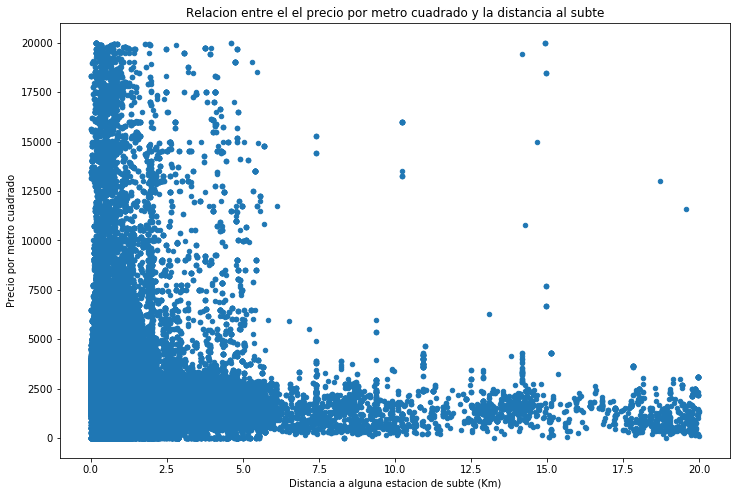

In [86]:
dist = solo_capital.loc[(solo_capital.price_usd_per_m2.notnull()) & (solo_capital.price_usd_per_m2 < 20000) & (solo_capital.distancia_subtes < 20),:]
plot = dist.plot.scatter(x = 'distancia_subtes', y = 'price_usd_per_m2', figsize=(12,8));
plot.set_xlabel("Distancia a alguna estacion de subte (Km)")
plot.set_ylabel("Precio por metro cuadrado")
plot.set_title("Relacion entre el el precio por metro cuadrado y la distancia al subte")

In [67]:
# link con algunos colores para los graficos
# https://matplotlib.org/users/colors.html

In [87]:
# Lo de lo subtes no se si corre porque lo deje un rato y seguia sin terminar y me tenia q ir.
# por ahi lo pruebe aparte en otro notebook para tener mas libre la ram haciendolo solo con lo que necesite

#Lo corri y tardo media hora, lo exporte a csv, te lo paso maniana